In [1]:
import argparse
import os
os.umask(0)
os.environ["MKL_NUM_THREADS"] = "8"
os.environ["NUMEXPR_NUM_THREADS"] = "8"
os.environ["OMP_NUM_THREADS"] = "8"

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

import pickle
import sys
from importlib import import_module

import torch
from torch.utils.data import DataLoader, Sampler
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm

from data import InteDataset
from data import ArgoTestDataset
from utils import Logger, load_pretrain

# define parser
parser = argparse.ArgumentParser(description="Argoverse Motion Forecasting in Pytorch")
parser.add_argument(
    "-m", "--model", default="lanegcn", type=str, metavar="MODEL", help="model name"
)
parser.add_argument("--eval", action="store_true", default=True)
parser.add_argument(
    "--split", type=str, default="val", help='data split, "val" or "test"'
)
parser.add_argument(
    "--weight", default="/media/drl/datas/zyk/LaneGCN/results/lanegcn_interaction/36.000.ckpt", type=str, metavar="WEIGHT", help="checkpoint path"
)
# parser.add_argument(
#     "--weight", default="/media/drl/datas/zyk/LaneGCN/results/lanegcn/17.000.ckpt", type=str, metavar="WEIGHT", help="checkpoint path"
# )


_StoreAction(option_strings=['--weight'], dest='weight', nargs=None, const=None, default='/media/drl/datas/zyk/LaneGCN/results/lanegcn_interaction/36.000.ckpt', type=<class 'str'>, choices=None, help='checkpoint path', metavar='WEIGHT')

In [2]:
root_path = '/home/user/Projects/LaneGCN_modified'
sys.path.insert(0, root_path)

model = import_module("lanegcn")
config, _, collate_fn, net, loss, post_process, opt = model.get_model()


In [ ]:
config

In [3]:
ckpt_path = "/home/user/Projects/interaction_gyt/preprocess_results_10s_for_training_EEMG/results/80.000.ckpt"
# ckpt_path = "/media/drl/datas/zyk/LaneGCN/results/lanegcn/17.000.ckpt"

if not os.path.isabs(ckpt_path):
    ckpt_path = os.path.join(config["save_dir"], ckpt_path)
ckpt = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
load_pretrain(net, ckpt["state_dict"])
net.eval()


Net(
  (actor_net): ActorNet(
    (groups): ModuleList(
      (0): Sequential(
        (0): Res1d(
          (conv1): Conv1d(3, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (relu): ReLU(inplace=True)
          (bn1): GroupNorm(1, 32, eps=1e-05, affine=True)
          (bn2): GroupNorm(1, 32, eps=1e-05, affine=True)
          (downsample): Sequential(
            (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,), bias=False)
            (1): GroupNorm(1, 32, eps=1e-05, affine=True)
          )
        )
        (1): Res1d(
          (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (relu): ReLU(inplace=True)
          (bn1): GroupNorm(1, 32, eps=1e-05, affine=True)
          (bn2): GroupNorm(1, 32, eps=1e-05, affine=True)
        )
      )
    

In [95]:
filepath = '/home/user/Projects/interaction_gyt/preprocess_results_10s_invalid_use_csv_EP0_with_opponents_psi/test'
dataset = InteDataset(filepath)
# dataset = InteDataset('/home/user/Datasets/raw_map/preprocess_results_5s/tmp/')
data_loader = DataLoader(
    dataset,
    batch_size=config["val_batch_size"],
    num_workers=config["val_workers"],
    collate_fn=collate_fn,
    shuffle=False,
    pin_memory=False,
)

# begin inference
preds = {}
gts = {}
cities = {}

data_list = []
for ii, data in tqdm(enumerate(data_loader)):
    data = dict(data)
    with torch.no_grad():
        
        output = net(data)
        loss_out = loss(output, data)
        results = [x.detach().cpu().numpy() for x in output["reg"]]

        for idx in range(len(results)):
            filename = data['filename'][idx].split('/')[-1]
            with open(os.path.join(filepath, filename), 'rb') as f:
                origin_data = pickle.load(f, encoding="latin1")

            new_data = {}
            with open(os.path.join('/home/user/Projects/interaction_gyt/preprocess_results_10s_invalid_use_csv_EP0_with_opponents_psi/test_0826', filename), 'wb') as f22:
                new_data['filename'] = filename
                new_data['ctrs'] = origin_data['ctrs'] 
                new_data['orig'] = origin_data['orig'] 
                new_data['theta'] = origin_data['theta'] 
                new_data['shapes'] = origin_data['shapes'] 
                
                new_data['start_timestamp'] = filename.split('_')[1]
                new_data['ego_id'] = origin_data['idx']
                

                arr_A = []
                for a in range(len(results[idx])):
                    arr_K = []
                    for k in range(6):
                        pred_traj, gt_hist, traj_interval_vel = interval(data, results, idx, a, k)
                        arr_K.append(traj_interval_vel)
                    arr_A.append(arr_K)

                new_data['traj_a_k'] = arr_A
                pickle.dump(new_data, f22, protocol=pickle.HIGHEST_PROTOCOL)


27it [01:32,  3.42s/it]


In [ ]:
print(data.keys())
data['filename'][0].split('/')[-1]
origin_data['orig']

In [42]:
origin_data.keys()
data['gt_hist']

[[tensor([[ 9.7462e+02,  9.8387e+02, -5.7000e-02],
          [ 9.7514e+02,  9.8385e+02, -5.5000e-02],
          [ 9.7565e+02,  9.8382e+02, -5.3000e-02],
          [ 9.7614e+02,  9.8380e+02, -5.0000e-02],
          [ 9.7663e+02,  9.8378e+02, -4.8000e-02],
          [ 9.7710e+02,  9.8376e+02, -4.6000e-02],
          [ 9.7755e+02,  9.8374e+02, -4.5000e-02],
          [ 9.7799e+02,  9.8372e+02, -4.3000e-02],
          [ 9.7841e+02,  9.8371e+02, -4.2000e-02],
          [ 9.7881e+02,  9.8369e+02, -4.1000e-02],
          [ 9.7920e+02,  9.8367e+02, -4.1000e-02],
          [ 9.7956e+02,  9.8366e+02, -4.0000e-02],
          [ 9.7990e+02,  9.8365e+02, -4.0000e-02],
          [ 9.8022e+02,  9.8363e+02, -4.0000e-02],
          [ 9.8052e+02,  9.8362e+02, -4.1000e-02],
          [ 9.8080e+02,  9.8361e+02, -4.1000e-02],
          [ 9.8106e+02,  9.8359e+02, -4.2000e-02],
          [ 9.8131e+02,  9.8358e+02, -4.3000e-02],
          [ 9.8154e+02,  9.8357e+02, -4.3000e-02],
          [ 9.8175e+02,  9.8356

In [15]:
arr_T = []
for idx in range(len(results)):
    arr_A = []
    for a in range(len(results[idx])):
        arr_K = []
        for k in range(6):
            pred_traj, gt_hist, traj_interval_vel = interval(data, results, idx, a, k)
            arr_K.append(traj_interval_vel)
        arr_A.append(arr_K)
    arr_T.append(arr_A)
arr_T

[[[array([[ 974.61999512,  983.87298584,    5.18707386],
          [ 975.13800049,  983.8460083 ,    5.13632984],
          [ 975.64599609,  983.82202148,    5.03051573],
          [ 976.62799072,  983.77697754,    4.77969922],
          [ 977.55297852,  983.73901367,    4.46865574],
          [ 978.4119873 ,  983.70501709,    4.11291215],
          [ 979.19500732,  983.67401123,    3.71804876],
          [ 979.89801025,  983.64599609,    3.31756265],
          [ 980.52001953,  983.61999512,    2.9179366 ],
          [ 981.06402588,  983.5949707 ,    2.53770458],
          [ 981.74902344,  983.56201172,    2.04605705],
          [ 982.31591797,  983.50238037,    1.96318878],
          [ 982.89874268,  983.50823975,    2.03940289],
          [ 983.453125  ,  983.44281006,    1.60868573],
          [ 984.04803467,  983.35650635,    2.09072473],
          [ 984.65795898,  983.23681641,    1.86649959],
          [ 985.27960205,  983.26092529,    2.21411442],
          [ 985.99108887,  983.

In [ ]:
print(new_data.keys())

In [9]:
feats = data['feats'][idx]

fake_ctrs = np.array([45, 8, 1])
tmp_ctrs = torch.cat([data['ctrs'][idx], torch.tensor(fake_ctrs[:2], dtype=torch.float).reshape(1, -1)])

fake_theta = np.pi
# data['theta'].append(fake_theta)

fake_feat = [[50-(50-fake_ctrs[0])*i/20 , fake_ctrs[1] , 1] for i in range(20)]
fake_feat = torch.tensor(fake_feat, dtype=torch.float).reshape(1, 20, -1)
tmp_feats = torch.cat([data['feats'][idx], fake_feat])
# data['feats'][idx]

tmp_has_preds = torch.cat([data['has_preds'][idx], data['has_preds'][idx][-1].reshape(1, -1)])

fake_rot_ctrs = torch.tensor(fake_ctrs[:2], dtype=torch.float)
fake_gt_preds = torch.cat([fake_rot_ctrs.reshape(1, -1) for i in range(config['pred_size'])], 0)
fake_gt_preds = torch.matmul(fake_gt_preds, data['rot'][0]) + data['orig'][idx]
tmp_gt_preds = torch.cat([data['gt_preds'][idx], fake_gt_preds.reshape(1, -1, 2)])

                           
tmp_steps = torch.cat([data['steps'][idx], data['steps'][idx][-1].reshape(1, -1)])

data['has_preds'][idx] = tmp_has_preds
data['gt_preds'][idx] = tmp_gt_preds
data['feats'][idx] = tmp_feats
data['theta'].append(fake_theta)
data['ctrs'][idx] = tmp_ctrs

with torch.no_grad():
    data = dict(data)

    output = net(data)
    results = [x.detach().cpu().numpy() for x in output["reg"]]
    display = post_process(output, data)

NameError: name 'np' is not defined

In [10]:
def traj_plot(traj, rot, orig, ax=None, c="", s=[]):

    
    if isinstance(traj, torch.Tensor):
        traj = traj.numpy()
    rot = rot.numpy()
    orig = orig.numpy()
    
    centerline = np.array([traj[:, 0] - orig[0], traj[:, 1] - orig[1]]).T
#     print(centerline)
    centerline = np.matmul(rot, (centerline.reshape(-1, 2)).T).T

    if ax is not None:
        ax.plot(centerline[:, 0], centerline[:, 1], c, s)
        
    return centerline

def dis(x0, x1, y0, y1):
    return np.sqrt((x0-x1)**2 + (y0-y1)**2)


In [ ]:
data.keys()

In [ ]:
# print(hist.cpu().detach().numpy()[:, :2])
# print(pred_traj)
# print(len(data['gt_hist'][0][0]))
# print(np.concatenate([gt_hist, pred_traj]))
print(np.array(traj_interval).shape)
print(np.array(velo_interval).shape)
print(np.expand_dims(np.array(velo_interval), axis=1).shape)
print(np.concatenate([np.array(traj_interval), np.expand_dims(np.array(velo_interval), axis=1)], axis=1))

In [79]:
def interval(data, results, idx, a, k):
    pred_traj = np.insert(results[idx][a, k, :, :], 2, values=None, axis=1)
    gt_hist = data['gt_hist'][idx][a].cpu().detach().numpy()
    traj_origin = np.concatenate([gt_hist, pred_traj])

    # 起点
    traj_interval = [traj_origin[0]]
    velo_interval = [dis(traj_origin[1][0], traj_origin[0][0], traj_origin[1][1], traj_origin[0][1]) * 10]
    for i in range(1, traj_origin.shape[0] - 1):
        if dis(traj_origin[i][0], traj_interval[-1][0], traj_origin[i][1], traj_interval[-1][1]) >= thrd:
            traj_origin[i][2] = np.arctan2(traj_origin[i][1] - traj_interval[-1][1], traj_origin[i][0] - traj_interval[-1][0])
            traj_interval.append(traj_origin[i])
            vel = dis(traj_origin[i + 1][0], traj_origin[i - 1][0], traj_origin[i + 1][1], traj_origin[i - 1][1])
            velo_interval.append(vel * 5)
    # 终点
    traj_origin[-1][2] = np.arctan2(traj_origin[-1][1] - traj_interval[-1][1], traj_origin[-1][0] - traj_interval[-1][0])
    traj_interval.append(traj_origin[-1])
    velo_interval.append(dis(traj_origin[-1][0], traj_origin[-2][0], traj_origin[-1][1], traj_origin[-2][1]) * 10)
    #         print(output['cls'][idx][a][k])

    traj_interval_vel = np.concatenate([np.array(traj_interval), np.expand_dims(np.array(velo_interval), axis=1)], axis=1)
    return pred_traj, gt_hist, traj_interval_vel
        
pred_traj, gt_hist, traj_interval_vel = interval(data, results, idx, a, k)
traj_interval_vel

array([[ 9.74619995e+02,  9.83872986e+02, -5.70000000e-02,
         5.18707386e+00],
       [ 9.76627991e+02,  9.83776978e+02, -4.77766171e-02,
         4.77969922e+00],
       [ 9.78812988e+02,  9.83689026e+02, -4.02308032e-02,
         3.91816830e+00],
       [ 9.81064026e+02,  9.83594971e+02, -4.17587422e-02,
         2.53770458e+00],
       [ 9.83086853e+02,  9.83527649e+02, -3.32687534e-02,
         1.81432433e+00],
       [ 9.85279602e+02,  9.83260925e+02, -1.21044271e-01,
         2.21411442e+00],
       [ 9.87508850e+02,  9.83277405e+02,  7.39226490e-03,
         3.29592155e+00],
       [ 9.89580139e+02,  9.83511597e+02,  1.12587631e-01,
         4.30050927e+00],
       [ 9.91640076e+02,  9.83967712e+02,  2.17906460e-01,
         4.65149840e+00],
       [ 9.93877808e+02,  9.84882629e+02,  3.88120115e-01,
         4.89521095e+00],
       [ 9.95789124e+02,  9.85924683e+02,  4.99152035e-01,
         3.66613859e+00],
       [ 9.97529785e+02,  9.87480591e+02,  7.29412556e-01,
      

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3 and the array at index 1 has size 2

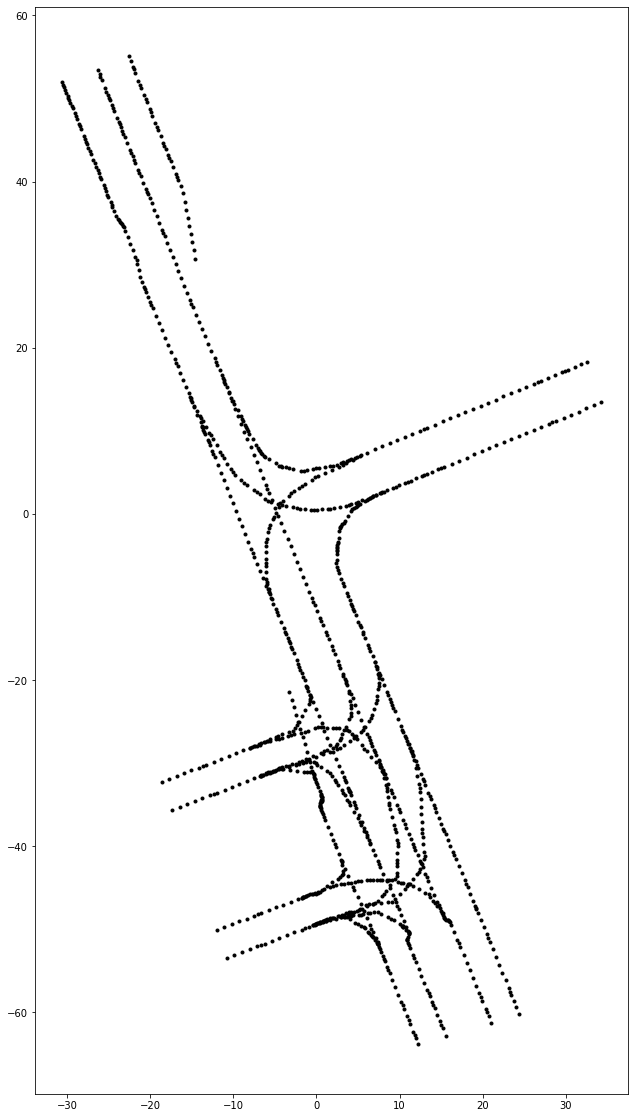

In [45]:
import numpy as np
import matplotlib.pyplot as plt
idx = 12
thrd = 2.0


orig = data['orig'][idx]
rot = data['rot'][idx]
graph = data['graph'][idx]
    


gt_preds = data['gt_preds'][idx]
has_preds = data['has_preds'][idx]
for k in range(6):
    fig, ax = plt.subplots(1,1, figsize=(20,20))
    ax.set_aspect('equal', adjustable='box')
#     plt.gca().invert_xaxis()
#     plt.gca().invert_yaxis()     

    ctrs = graph['ctrs']
    ax.plot(ctrs[:, 0], ctrs[:, 1], 'k.')
    for a in range(data['gt_preds'][idx].shape[0]):
#         if a != 0:
#             continue
        
        mask = has_preds[a]
        gt_pred = gt_preds[a][mask]
        
        hist = data['feats'][idx][a]
        for l in data['ref_paths'][idx][a]:
            lane = torch.matmul(l - data['orig'][idx], rot.T)
#             plt.plot(lane[:, 0], lane[:, 1], 'g')
#         traj_plot(gt_pred,  rot, orig, ax, 'r.')

        pred_traj, gt_hist, traj_interval_vel = interval(data, results, idx, a, k)

        traj = torch.matmul(output['reg'][idx][a][k].cpu() - data['orig'][idx], rot.T)
        diff = traj[1:] - traj[:-1]
#         S_pred = torch.sum(torch.sqrt(torch.sum(diff ** 2, axis=1)))

        min_final_dis = float('inf')
        min_final_lane = None
        min_final_pt = None
        for ref in data['ref_paths'][idx][a]:
            if ref is None:
                continue
            
            Lane = torch.matmul(ref - data['orig'][idx], rot.T)
            map_car0 = Lane - traj[-1]
            lane_end_id = torch.argmin(torch.sum(map_car0 ** 2, 1))
#             plt.plot(Lane[:, 0], Lane[:, 1], 'g')

            final_pt = Lane[lane_end_id]
#             plt.scatter(final_pt[0], final_pt[1], s=150)
        
            final_dis = torch.sqrt(torch.sum((final_pt - traj[-1]) ** 2))
#             print(final_pt, traj[-1], final_dis)
            if min_final_dis > final_dis:
                min_final_dis = final_dis
                min_final_lane = Lane
                min_final_pt = final_pt
            
#         plt.plot(min_final_lane[:, 0], min_final_lane[:, 1], 'g', linewidth=3)
        
        traj_plot(gt_pred,  rot, orig, ax, 'r.')
#         traj_plot(pred_traj, rot, orig, ax, 'b.')
        traj_plot(traj_interval_vel, rot, orig, ax, 'b*')
        plt.plot(hist[:, 0], hist[:, 1], 'y.')

        plt.scatter(min_final_pt[0], min_final_pt[1], s=150)
#     plt.savefig('/home/user/Projects/LaneGCN_modified/results/remote_results/0603_5s/' + str(idx) + '_' + str(k))
#     plt.savefig('/home/user/Logs/0722/test/laneloss' + str(idx) + '_' + str(k))
    plt.show()


In [24]:
pred_traj
gt_hist

array([[ 998.618, 1022.147],
       [ 998.589, 1021.621],
       [ 998.559, 1021.096],
       [ 998.53 , 1020.573],
       [ 998.502, 1020.054],
       [ 998.474, 1019.541],
       [ 998.446, 1019.035],
       [ 998.419, 1018.539],
       [ 998.393, 1018.053],
       [ 998.368, 1017.58 ],
       [ 998.344, 1017.121],
       [ 998.32 , 1016.677],
       [ 998.297, 1016.249],
       [ 998.275, 1015.837],
       [ 998.253, 1015.443],
       [ 998.232, 1015.066],
       [ 998.212, 1014.707],
       [ 998.193, 1014.366],
       [ 998.174, 1014.042],
       [ 998.156, 1013.735]], dtype=float32)

tensor(7.9900, device='cuda:0')
tensor(5.2388, device='cuda:0')
tensor(9.0776, device='cuda:0')
tensor(4.3813, device='cuda:0')
tensor(7.4911, device='cuda:0')
tensor(3.4400, device='cuda:0')
tensor(-0.3743, device='cuda:0')


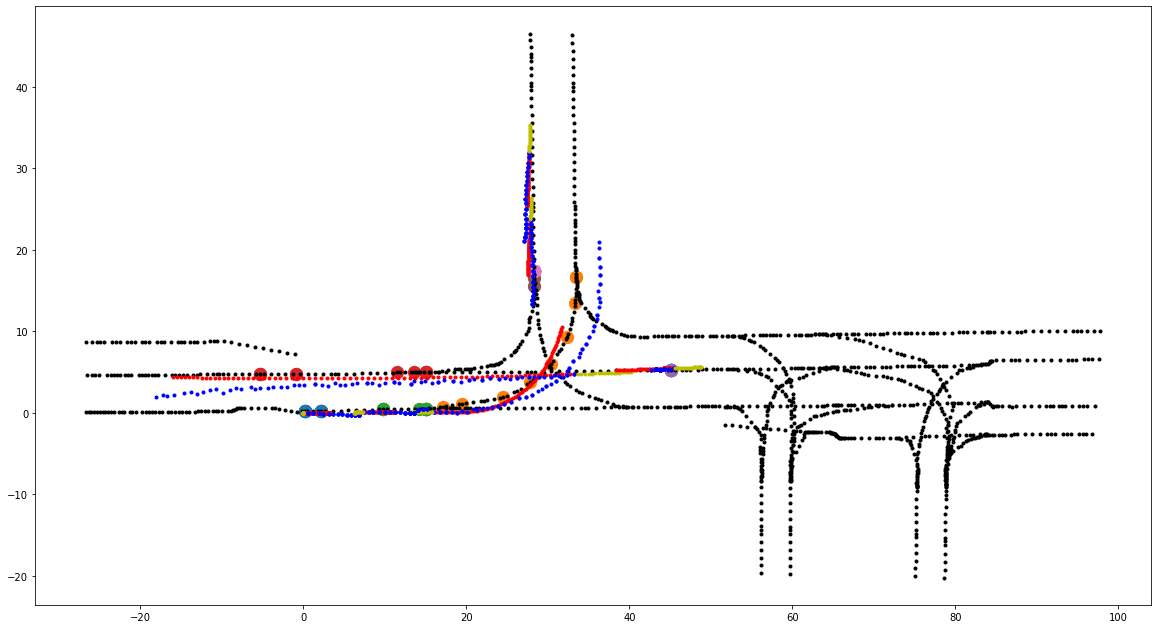

tensor(7.5782, device='cuda:0')
tensor(5.1164, device='cuda:0')
tensor(8.9517, device='cuda:0')
tensor(4.2101, device='cuda:0')
tensor(7.3083, device='cuda:0')
tensor(3.3299, device='cuda:0')
tensor(-0.4384, device='cuda:0')


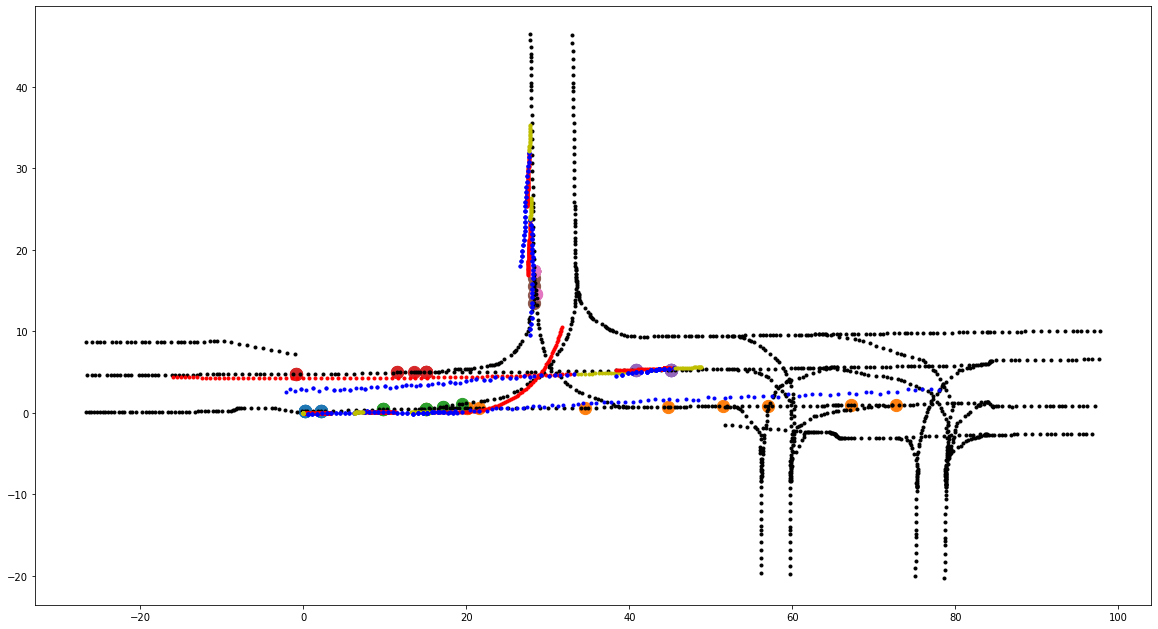

tensor(7.4014, device='cuda:0')
tensor(5.0908, device='cuda:0')
tensor(8.9432, device='cuda:0')
tensor(4.1795, device='cuda:0')
tensor(7.2643, device='cuda:0')
tensor(3.1943, device='cuda:0')
tensor(-0.6523, device='cuda:0')


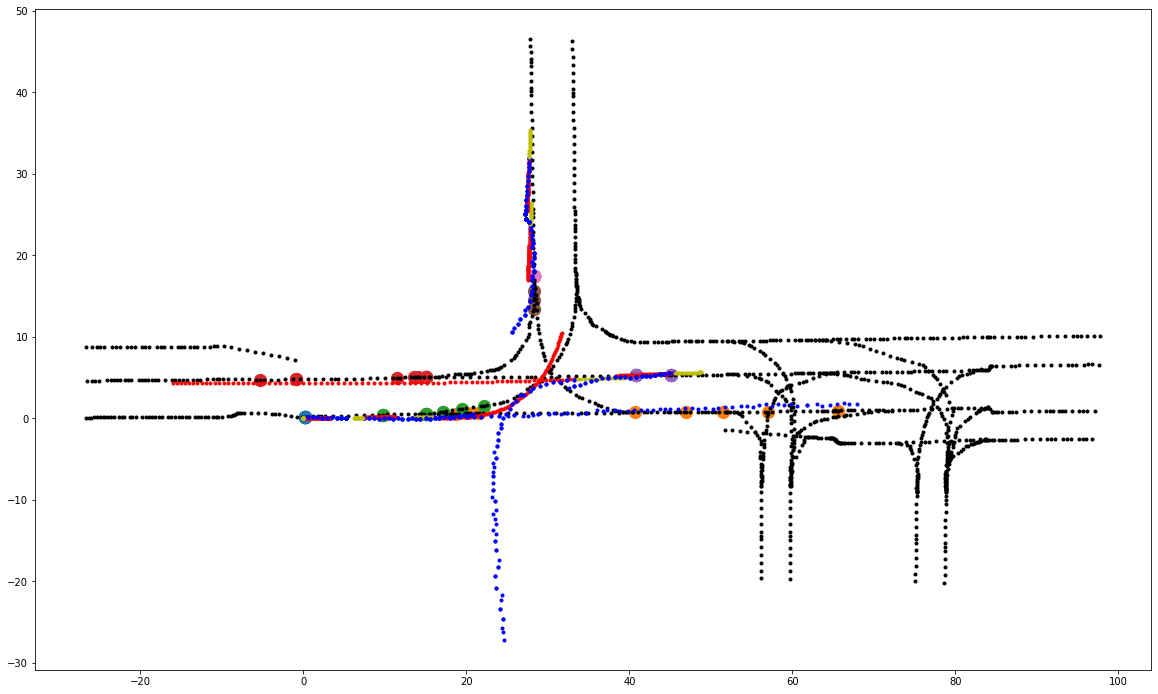

tensor(7.3159, device='cuda:0')
tensor(5.0487, device='cuda:0')
tensor(8.8804, device='cuda:0')
tensor(4.1558, device='cuda:0')
tensor(7.2311, device='cuda:0')
tensor(3.0156, device='cuda:0')
tensor(-0.8102, device='cuda:0')


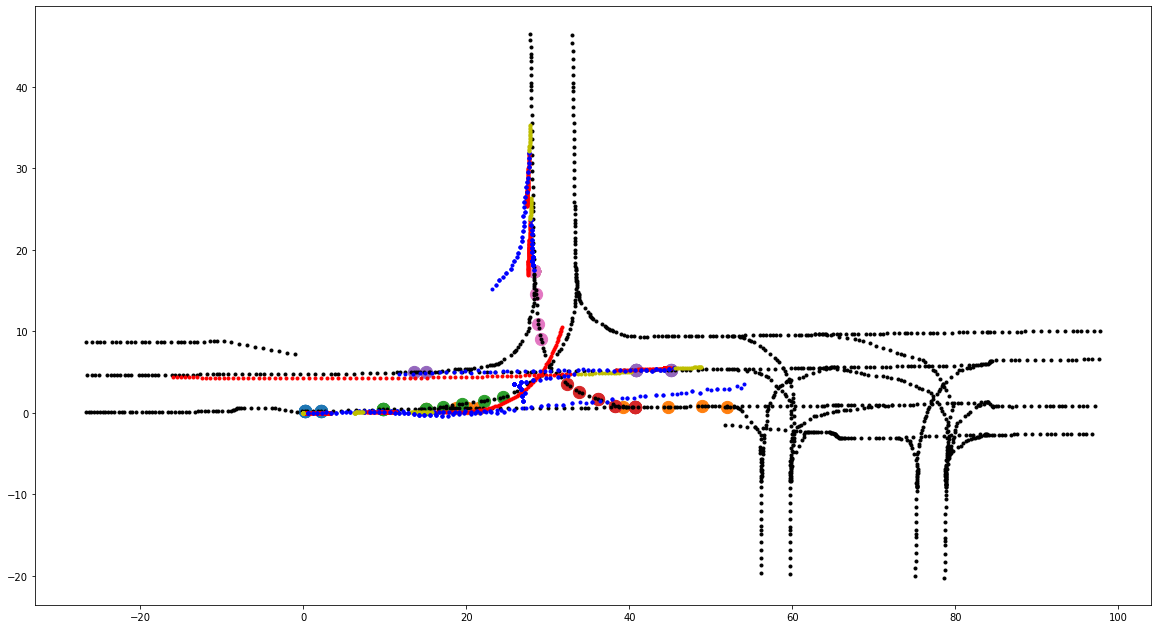

tensor(7.1111, device='cuda:0')
tensor(4.8210, device='cuda:0')
tensor(8.6920, device='cuda:0')
tensor(4.0768, device='cuda:0')
tensor(7.2177, device='cuda:0')
tensor(2.7795, device='cuda:0')
tensor(-1.0244, device='cuda:0')


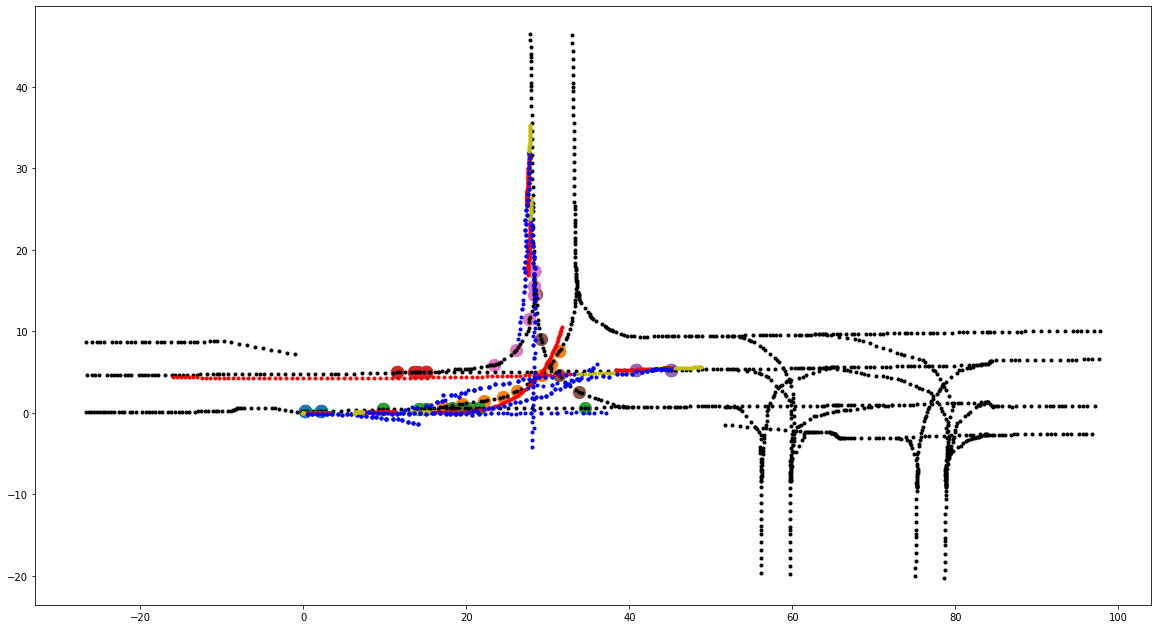

tensor(6.7452, device='cuda:0')
tensor(4.6074, device='cuda:0')
tensor(8.6366, device='cuda:0')
tensor(3.8750, device='cuda:0')
tensor(6.7288, device='cuda:0')
tensor(2.4137, device='cuda:0')
tensor(-1.6595, device='cuda:0')


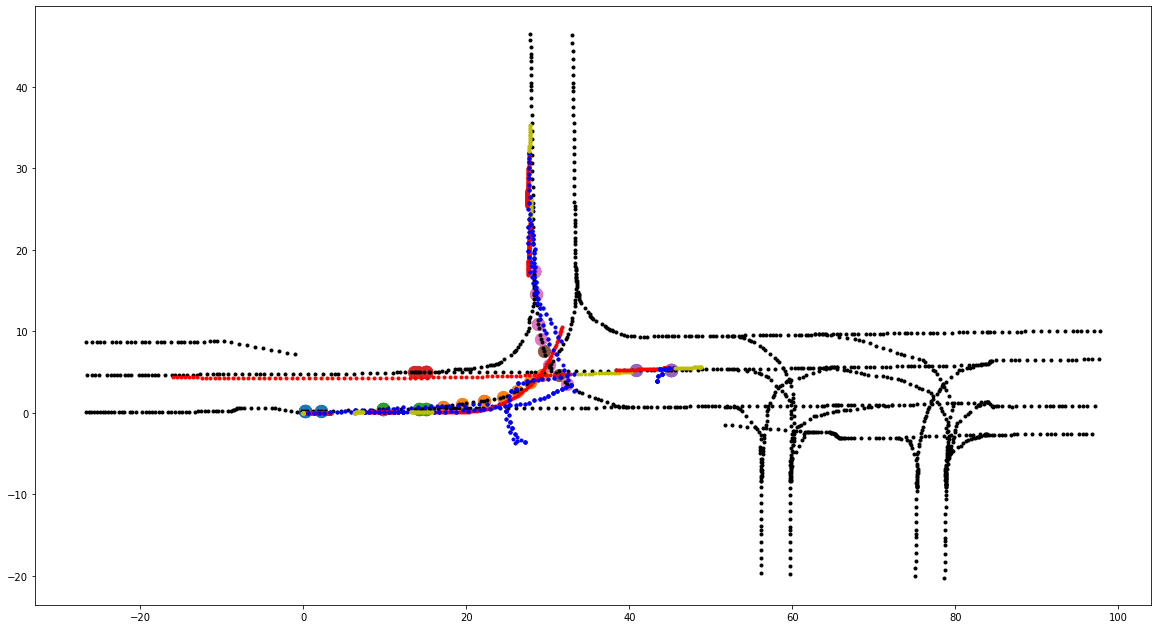

In [27]:
import numpy as np
import matplotlib.pyplot as plt
idx = 2
thrd = 0.5


orig = data['orig'][idx]
rot = data['rot'][idx]
graph = data['graph'][idx]
    



gt_preds = data['gt_preds'][idx]
has_preds = data['has_preds'][idx]
for k in range(6):
    fig, ax = plt.subplots(1,1, figsize=(20,20))
    ax.set_aspect('equal', adjustable='box')
#     plt.gca().invert_xaxis()
#     plt.gca().invert_yaxis()     

    ctrs = graph['ctrs']
    ax.plot(ctrs[:, 0], ctrs[:, 1], 'k.')
    for a in range(data['gt_preds'][idx].shape[0]):
#         if a != 0:
#             continue
        
        mask = has_preds[a]
        gt_pred = gt_preds[a][mask]
        
        hist = data['feats'][idx][a]
#         plt.plot(hist[:, 0], hist[:, 1], 'y.')
        for l in data['ref_paths'][idx][a]:
            lane = torch.matmul(l - data['orig'][idx], rot.T)
#             plt.plot(lane[:, 0], lane[:, 1], 'g')
#         traj_plot(gt_pred,  rot, orig, ax, 'r.')

        pred_traj = results[idx][a, k, :, :]
        for i in range(1, pred_traj.shape[0]):
            if dis(pred_traj[i][0], pred_traj[i - 1][0], pred_traj[i][1], pred_traj[i - 1][1]) < thrd:
                results[idx][a, k][i] = results[idx][a, k][i - 1]
#         traj_plot(pred_traj, rot, orig, ax, 'b.')
        print(output['cls'][idx][a][k])
        
        
        traj = torch.matmul(output['reg'][idx][a][k].cpu() - data['orig'][idx], rot.T)
        diff = traj[1:] - traj[:-1]
#         S_pred = torch.sum(torch.sqrt(torch.sum(diff ** 2, axis=1)))

        lane_pts = torch.matmul(output['lane_pts'][idx][a][k].cpu() - data['orig'][idx], rot.T)

#         min_final_dis = float('inf')
#         min_final_lane = None
#         min_final_pt = None
#         for ref in data['ref_paths'][idx][a]:
#             if ref is None:
#                 continue
            
#             Lane = torch.matmul(ref - data['orig'][idx], rot.T)
#             map_car0 = Lane - traj[-1]
#             lane_end_id = torch.argmin(torch.sum(map_car0 ** 2, 1))

#             final_pt = Lane[lane_end_id]
        
#             final_dis = torch.sqrt(torch.sum((final_pt - traj[-1]) ** 2))
#             if min_final_dis > final_dis:
#                 min_final_dis = final_dis
#                 min_final_lane = Lane
#                 min_final_pt = final_pt
            
        
        traj_plot(gt_pred,  rot, orig, ax, 'r.')
        traj_plot(pred_traj, rot, orig, ax, 'b.')
        plt.plot(hist[:, 0], hist[:, 1], 'y.')

#         plt.scatter(min_final_pt[0], min_final_pt[1], s=150)
        plt.scatter(lane_pts[:,0], lane_pts[:,1], s=150)
        
#     plt.savefig('/home/user/Projects/LaneGCN_modified/results/remote_results/0603_5s/' + str(idx) + '_' + str(k))
#     plt.savefig('/home/user/Logs/0826/' + str(idx) + '_' + str(k))
    plt.show()


In [28]:
data['gt_hist']

[[tensor([[ 997.8690, 1003.4590],
          [ 997.8630, 1003.2570],
          [ 997.8590, 1003.0650],
          [ 997.8540, 1002.8830],
          [ 997.8500, 1002.7100],
          [ 997.8460, 1002.5460],
          [ 997.8420, 1002.3890],
          [ 997.8390, 1002.2400],
          [ 997.8360, 1002.0950],
          [ 997.8330, 1001.9560],
          [ 997.8300, 1001.8190],
          [ 997.8280, 1001.6850],
          [ 997.8250, 1001.5520],
          [ 997.8220, 1001.4170],
          [ 997.8190, 1001.2810],
          [ 997.8160, 1001.1420],
          [ 997.8130, 1000.9980],
          [ 997.8090, 1000.8480],
          [ 997.8050, 1000.6910],
          [ 997.8010, 1000.5260]]),
  tensor([[ 999.4870,  992.3260],
          [ 999.6380,  992.0610],
          [ 999.7980,  991.7960],
          [ 999.9670,  991.5310],
          [1000.1450,  991.2670],
          [1000.3320,  991.0040],
          [1000.5300,  990.7420],
          [1000.7370,  990.4810],
          [1000.9550,  990.2220],
          [1

[[ 9.59804016e+02  9.85513000e+02 -8.10000002e-02  3.74354527e+00]
 [ 9.61953979e+02  9.85328003e+02 -8.58354196e-02  3.42792202e+00]
 [ 9.64223022e+02  9.85137024e+02 -8.39692950e-02  3.07018803e+00]
 [ 9.66511841e+02  9.84985168e+02 -6.62495717e-02  2.51398506e+00]
 [ 9.68746582e+02  9.85007385e+02  9.94122494e-03  2.62544216e+00]
 [ 9.70744080e+02  9.84842712e+02 -8.22535753e-02  2.59257474e+00]
 [ 9.73053955e+02  9.84388794e+02 -1.94039553e-01  3.71912169e+00]
 [ 9.75197632e+02  9.84372253e+02 -7.71580823e-03  1.25424235e+00]
 [ 9.77250732e+02  9.84075195e+02 -1.43690407e-01  2.61982452e+00]
 [ 9.79405457e+02  9.83931213e+02 -6.67223260e-02  2.96141301e+00]
 [ 9.81556152e+02  9.83729309e+02 -9.36042592e-02  4.40540554e+00]
 [ 9.83625610e+02  9.83618164e+02 -5.36557585e-02  4.06928172e+00]
 [ 9.86188843e+02  9.83359375e+02 -1.00621037e-01  5.67313228e+00]
 [ 9.88211853e+02  9.82975281e+02 -1.87629461e-01  5.08065104e+00]
 [ 9.90317688e+02  9.82890442e+02 -4.02657464e-02  5.55246556e

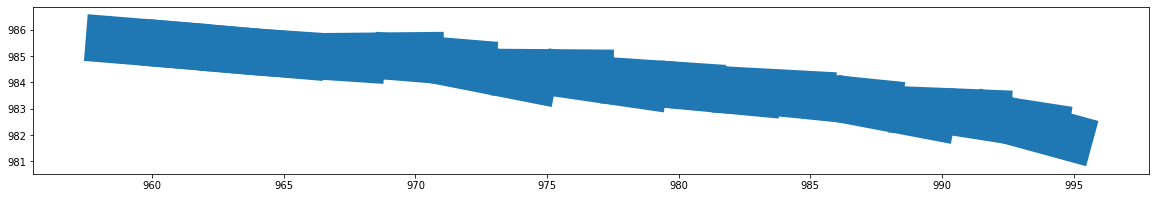

In [93]:
k = 4

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes
from matplotlib.patches import Polygon,Circle
from matplotlib.collections import PatchCollection


def rect_plot(pos, rot, orig, w, l, ax, c):
    rot = rot.numpy()
    orig = orig.numpy()    

    ax.plot(centerline[:, 0], centerline[:, 1], c)
    return centerline

def polygon_xy_from_motionstate(ms, width, length):
    lowleft = (ms[0] - length / 2., ms[1] - width / 2.)
    lowright = (ms[0] + length / 2., ms[1] - width / 2.)
    upright = (ms[0] + length / 2., ms[1] + width / 2.)
    upleft = (ms[0] - length / 2., ms[1] + width / 2.)
    return rotate_around_center(np.array([lowleft, lowright, upright, upleft]), np.array([ms[0], ms[1]]), yaw=ms[2])

def rotate_around_center(pts, center, yaw):
    return np.dot(pts - center, np.array([[np.cos(yaw), np.sin(yaw)], [-np.sin(yaw), np.cos(yaw)]])) + center


import csv

csv_file = '/home/user/Projects/interaction_gyt/recorded_trackfiles/DR_USA_Intersection_EP0/vehicle_tracks_000.csv'
widths = {}
lengths = {}
with open(csv_file, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        track_id = row[0]
        if track_id not in widths:
            widths[track_id] = row[10]
            lengths[track_id] = row[9]


            
import numpy as np
import matplotlib.pyplot as plt
# idx = 3


orig = data['orig'][idx]
rot = data['rot'][idx]
graph = data['graph'][idx]
gt_preds = data['gt_preds'][idx]
has_preds = data['has_preds'][idx]

fig, ax = plt.subplots(1,1, figsize=(20, 20))
ax.set_aspect('equal', adjustable='box')

ctrs = graph['ctrs']
ax.plot(ctrs[:, 0], ctrs[:, 1], 'k.')


res_final_dis, res_final_lane, res_final_pt = [], [], []
entire_trajs = np.zeros([gt_preds.shape[0], 20 + config['pred_size'], 3])
for a in range(gt_preds.shape[0]):
    width, length = data['shapes'][idx][a]

    mask = has_preds[a]
    gt_pred = gt_preds[a][mask]

    hist = data['feats'][idx][a][:,:2]
    pred_traj = traj_plot(results[idx][a, k, :, :], rot, orig)
    plt.plot(hist[:, 0], hist[:, 1], 'y.')
    traj_plot(gt_pred,  rot, orig, ax, 'r.')
    
    sp_hist = spline5(hist.numpy()[:, 0], hist.numpy()[:, 1])
    pred_traj[0] = hist[-1]
    sp_pred = spline5(pred_traj[:, 0], pred_traj[:, 1])

    hist_T = hist.shape[0]
    for time_stamp in range(hist_T):
        x, y, dx, dy = sp_hist.cal(time_stamp / (hist_T - 1))
        entire_trajs[a, time_stamp, 0] = x
        entire_trajs[a, time_stamp, 1] = y
        entire_trajs[a, time_stamp, 2] = math.atan2(dy, dx)
        
    for time_stamp in range(config['pred_size']):
        x, y, dx, dy = sp_pred.cal(time_stamp / (config['pred_size'] - 1))
        entire_trajs[a, hist_T + time_stamp, 0] = x
        entire_trajs[a, hist_T + time_stamp, 1] = y
        entire_trajs[a, hist_T + time_stamp, 2] = math.atan2(dy, dx)
        
    min_final_dis = float('inf')
    min_final_lane = None
    min_final_pt = None
    
    for ref in data['ref_paths'][idx][a]:
        if ref is None:
            continue

        Lane = torch.matmul(ref - data['orig'][idx], rot.T)
        map_car0 = Lane - pred_traj[-1]
        lane_end_id = torch.argmin(torch.sum(map_car0 ** 2, 1))
    #             plt.plot(Lane[:, 0], Lane[:, 1], 'g')

        final_pt = Lane[lane_end_id]
    #             plt.scatter(final_pt[0], final_pt[1], s=150)

        final_dis = torch.sqrt(torch.sum((final_pt - pred_traj[-1]) ** 2))
    #             print(final_pt, traj[-1], final_dis)
        if min_final_dis > final_dis:
            min_final_dis = final_dis
            min_final_lane = Lane
            min_final_pt = final_pt
            
    res_final_dis.append(min_final_dis)
    res_final_lane.append(min_final_lane)
    res_final_pt.append(min_final_pt)
        
    plt.plot(min_final_lane[:, 0], min_final_lane[:, 1], 'g', linewidth=5)
    plt.scatter(min_final_pt[0], min_final_pt[1], s=150)

for time_stamp in range(entire_trajs.shape[1]):
    for a in range(gt_preds.shape[0]):
        ms = entire_trajs[a][time_stamp]
        rect = matplotlib.patches.Polygon(polygon_xy_from_motionstate(ms, width, length), closed=True, zorder=20)
        ax.add_patch(rect)


# ax.plot(entire_traj[:, 0], entire_traj[:, 1], 'b.')
    

#     plt.savefig('/home/user/Projects/LaneGCN_modified/results/remote_results/0603_5s/' + str(idx) + '_' + str(k))
#     plt.savefig('/home/user/Videos/0603/8s/' + str(idx) + '_' + str(k))
plt.show()

In [ ]:
%%time
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.colors as colors

def create_animation():
  """ Creates a Matplotlib animation of the given images."""

  plt.ioff()
  fig, ax = plt.subplots(1,1, figsize=(20, 20))

#   plt.gca().invert_xaxis()
#   plt.gca().invert_yaxis() 
    

  ax.set_aspect('equal', adjustable='box')
    
  plt.ion()
  ctrs = graph['ctrs']
  ax.plot(ctrs[:, 0], ctrs[:, 1], 'k.')

  for a in range(data['gt_preds'][idx].shape[0]):
#     hist = data['feats'][idx][a][:,:2]
#     plt.plot(hist[:, 0], hist[:, 1], 'y.')
#     traj_plot(gt_preds[a],  rot, orig, ax, 'r.')
    traj_plot(traj_interval_vel[:, :2],  rot, orig, ax, 'b.')
    
    plt.plot(res_final_lane[a][:, 0], res_final_lane[a][:, 1], 'g', linewidth=5)
    plt.scatter(res_final_pt[a][0], res_final_pt[a][1], s=150)
    

  def animate_func(time_stamp):
    ax.patches = []
    
    for a in range(data['gt_preds'][idx].shape[0]):
        ms = entire_trajs[a][time_stamp]
        rect = matplotlib.patches.Polygon(polygon_xy_from_motionstate(ms, width, length), closed=True, zorder=20)
        ax.add_patch(rect)


  anim = animation.FuncAnimation(
      fig, animate_func, frames=20+config['pred_size'], interval=100)
  plt.close(fig)
    
  return anim

anim = create_animation()
HTML(anim.to_html5_video())

In [ ]:
torch.softmax(output['cls'][0], -1)

In [ ]:
output['cls']

In [ ]:
torch.arange(prediction.shape[0])
prediction.get_device()

In [ ]:
from metrics import compute_joint_metrics
compute_joint_metrics(prediction, truth, [])

In [ ]:
import csv
from tqdm import tqdm

csv_prefix = '/home/user/Downloads/collected_id_pair'
csv_folders = os.listdir(csv_prefix)

larger_than_5s = 0
files_5s = []

larger_than_8s = 0
files_8s = []

larger_than_10s = 0
files_10s = []

total_count = 0

for folder in tqdm(csv_folders):
    csv_path = os.path.join(csv_prefix, folder)
    for name in os.listdir(csv_path):
        csv_file = os.path.join(csv_path, name)
#         print(csv_file)

        with open(csv_file, 'r') as f:
            reader = csv.reader(f)
            for i in reader:
                total_count += 1
#                 print(i[3], i[4], i[5])
                if int(i[5]) - int(i[4]) > 5000:
                    larger_than_5s += 1
                    files_5s.append([i[3:]])
                    
                if int(i[5]) - int(i[4]) > 8000:
                    larger_than_8s += 1
                    files_8s.append([i[3:]])
                    
                if int(i[5]) - int(i[4]) > 10000:
                    larger_than_10s += 1
                    files_10s.append([i[3:]])


In [ ]:
print('5s ', larger_than_5s)
print('8s ', larger_than_8s)
print('10s', larger_than_10s)
total_count

In [ ]:
print(entire_trajs[a].shape)
Xseq = entire_trajs[a][:, 0]
Yseq = entire_trajs[a][:, 1]

# print(Xseq)
# print(Yseq)
# spx = spline5(Xseq)
# spy = spline5(Yseq)

# spx.cal(1)
# spy.cal(1)

# spx.plot_scatter()
# spy.plot_scatter()

sp = spline5(Xseq, Yseq)
print(sp.cal(0.0))
print(sp.cal(1.0))
sp.plot_scatter()

In [81]:
# from cvxopt  import solvers, matrix
import numpy as np
from qpsolvers import solve_qp
from numpy import array, dot
import sympy as sym
import math 

class spline5:
    def __init__(self, Xseq, Yseq, yaw=None):
        self.Xseq = Xseq
        self.Yseq = Yseq
        
        self.T = len(Xseq)
        order = 5
        self.order = order
        
        p = np.zeros([self.T * 2, (order + 1) * 2])
        q = np.zeros([self.T * 2, 1])
        for i in range(self.T):
            t = i / (self.T - 1)
            for j in range(order + 1):
                ttt = np.power(t, j)
                p[i][j] = ttt
                p[i + self.T][j + order + 1] = ttt
            q[i] = Xseq[i]
            q[i + self.T] = Yseq[i]
        
        bound = 2
###### -b <= d2y/d2x <= b
        g = np.zeros([self.T * 2, (order + 1) * 2])
        h = np.zeros([self.T * 2])
        for i in range(self.T):
            t = i / (self.T - 1)
            
            for j in range(2, order + 1):
                ttt = np.power(t, j-2)
                g[i][j]                 = -bound * j * (j-1) * ttt
                g[i][j + order + 1]     = j * (j-1) * ttt            
                
                g[i + self.T][j]        = -bound * j * (j-1) * ttt
                g[i + self.T][j + order + 1] = -j * (j-1) * ttt
        

####### -b <= d2x/d2y <= b
        g2 = np.zeros([self.T * 2, (order + 1) * 2])
        h2 = np.zeros([self.T * 2])
        for i in range(self.T):
            t = i / (self.T - 1)
            
            for j in range(2, order + 1):
                ttt = np.power(t, j-2)
                g2[i][j]                      = j * (j-1) * ttt            
                g2[i][j + order + 1]          = -bound * j * (j-1) * ttt
                
                g2[i + self.T][j]             = -j * (j-1) * ttt
                g2[i + self.T][j + order + 1] = -bound * j * (j-1) * ttt
        

####### 
        


        
#         np.set_printoptions(precision=2)
#         print('p', p)
#         P = np.dot(p.T, p) + np.dot(g.T, g) * 0.001 + np.eye((order + 1) * 2) * 0.0001
        P = np.dot(p.T, p) + np.eye((order + 1) * 2) * 0.01
        
        Q = -np.dot(q.T, p)
        Q = Q.reshape(((order + 1) * 2,))
        
        A = np.zeros([3, (order + 1) * 2])
        B = np.zeros([A.shape[0], 1])
        
        A[0][0] = 1
        A[1][order + 1] = 1
        B[0] = Xseq[0]
        B[1] = Yseq[0]
        
#         for j in range(order + 1):
#             A[2][j] = 1
#             A[3][j + order + 1] = 1
#         B[2] = Xseq[-1]
#         B[3] = Yseq[-1]
        
        if yaw is not None:
            A[-1][1] = math.tan(yaw) 
            A[-1][1+order+1] = -1

            B[-1] = 0
            
        B = B.reshape((A.shape[0],))
        
        
        G = np.concatenate([g, g2])
        H = np.concatenate([h, h2])
                
#         self.sol = solve_qp(P=P, q=Q)
        self.sol = solve_qp(P=P, q=Q, A=A, b=B)
#         self.sol = solve_qp(P=P, q=Q, A=A, b=B, G=G, h=H)



    def cal(self, t):
        x = 0
        y = 0
        order = self.order
        dx = 0
        dy = 0
        
        if t >= 0 and t <= 1:
            for i in range(order + 1):
                ttt = np.power(t, i)
                x += self.sol[i] * ttt
                y += self.sol[i + order + 1] * ttt

            for i in range(1, order + 1):    
                ttt = np.power(t, i - 1)
                dx += self.sol[i] * i * ttt
                dy += self.sol[i + order + 1] * i * ttt
        
        return x, y, dx, dy

    def plot_scatter(self):
        X, Y = [], []

        T = [i / (self.T - 1) for i in range(self.T)]
        for t in T:
            x, y, dx, dy = self.cal(t)
            X.append(x)
            Y.append(y)

            
        plt.scatter(T, X)
        plt.scatter(T, self.Xseq, color='red')
        plt.show()        
#     
        plt.scatter(T, Y)
        plt.scatter(T, self.Yseq, color='red')
        plt.show()

        plt.scatter(X, Y)
        plt.scatter(self.Xseq, self.Yseq, color='red')
        plt.show()

# sp = spline5(Xseq[::1], Yseq[::1])


In [ ]:
print(graph.keys())
print(data.keys())
print(graph['ctrs'].shape)
print(data['ctrs'][0].shape)

In [ ]:
print(graph['suc'][0]['u'].shape)
print(graph['suc'][0]['u'])

In [ ]:
ego_id = 1
data['ctrs'][0][ego_id]

In [ ]:
graph.keys()
lane_id = graph['lane_idcs'][ego_graph_id]
print("start point ctr id", lane_id)

torch.nonzero(graph['lane_idcs']==lane_id)

In [ ]:
def dfs(cur_graph_id, Lanes, lane, cur_len, S_pred, iter):
    graph_u = graph['suc'][0]['u']
    graph_v = graph['suc'][0]['v']
    
    suc_indices = (graph_u==cur_graph_id).nonzero()
    if cur_len > S_pred or suc_indices.shape[0] == 0 or iter > 100:
        Lanes.append(torch.stack(lane).long())
        print(cur_len, S_pred)
        print(Lanes[-1])
        return 
    
    for suc_id in suc_indices:
        lane.append(graph_v[suc_id[0]])
        
        s_diff = graph['ctrs'][graph_v[suc_id[0]]] - graph['ctrs'][graph_u[suc_id[0]]]
        s = torch.sqrt(torch.sum(s_diff ** 2))
#         print(s.numpy())
        dfs(graph_v[suc_id[0]], Lanes, lane, cur_len + s, S_pred, iter+1)
        lane.pop()

In [ ]:
Lanes = []
dfs(ego_graph_id, Lanes, [], 0, S_pred=100, iter=0)
frenet_lane = graph['ctrs'][Lanes[0]]
# print(frenet_lane)
# print(graph['ctrs'][ego_graph_id])

In [ ]:
ego_id = 1
k=3

pred = results[idx][ego_id][k]
diff = np.diff(pred, axis=0)
S_pred = np.sum(np.sqrt(np.sum(diff ** 2, axis=1)))

print(graph['ctrs'])
print(data['ctrs'][idx][ego_id, :])
map_car0 = graph['ctrs'] - data['ctrs'][idx][ego_id, :]
# map_car0 = graph['ctrs'] - torch.Tensor(np.array([990.57, 983.906]))
start = torch.sum(map_car0 ** 2, 1)

graph_u = graph['suc'][0]['u']
graph_v = graph['suc'][0]['v']

ego_graph_id = torch.argmin(start)
# ego_graph_id = 1281

print(ego_graph_id)
graph['ctrs'][ego_graph_id]
gt_preds.shape

fig, ax = plt.subplots(1,1, figsize=(40,40))
ax.set_aspect('equal', adjustable='box')
#     plt.gca().invert_xaxis()
#     plt.gca().invert_yaxis()     
# for a in range(data['gt_preds'][idx].shape[0]):
#     mask = has_preds[a]
#     gt_pred = gt_preds[a][mask]

#     hist = data['feats'][idx][a]
# #     plt.plot(hist[:, 0], hist[:, 1], 'y.')
# #     traj_plot(gt_pred,  rot, orig, ax, 'r.')

#     pred_traj = results[idx][a, k, :, :]
traj_plot(results[idx][ego_id][k], rot, orig, ax, 'b.')
    
traj_plot(gt_preds[ego_id],  rot, orig, ax, 'r.')


ctrs = graph['ctrs']
ax.plot(ctrs[:, 0], ctrs[:, 1], 'k.')

Lanes = []
dfs(ego_graph_id, Lanes, [], 0, S_pred, iter=0)
for Lane in Lanes:
    frenet_lane = graph['ctrs'][Lane]
    ax.plot(frenet_lane[:, 0], frenet_lane[:, 1], 'g*')
ax.plot([graph['ctrs'][ego_graph_id][0]], [graph['ctrs'][ego_graph_id][1]], 'r*')


plt.show()